In [1]:
import sys
sys.path.append("../../src")
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn.functional as F

import glob
import os
from datetime import datetime
import time
import math
from tqdm import tqdm

from itertools import repeat
from torch.nn.parameter import Parameter
import collections
import matplotlib
from torch_utils import *
from ContrastiveModels import *
from visualization import *
# matplotlib.use('Agg')

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize(mean=(0.0,), std=(1.0,))])

mnist_dset_train = torchvision.datasets.MNIST('../../data', train=True, transform=transform, target_transform=None, download=True)
train_loader = torch.utils.data.DataLoader(mnist_dset_train, batch_size=20, shuffle=True, num_workers=0)

mnist_dset_test = torchvision.datasets.MNIST('../../data', train=False, transform=transform, target_transform=None, download=True)
test_loader = torch.utils.data.DataLoader(mnist_dset_test, batch_size=20, shuffle=False, num_workers=0)

In [4]:
# # Best Hyperparameters so far
# activation = hard_sigmoid
# architecture = [784, 500, 10]

# beta = 1
# lambda_ = 0.99999
# epsilon = 0.15
# one_over_epsilon = 1 / epsilon
# lr_start = {'ff' : np.array([1, 0.75]), 'fb': np.array([0.15, 0.12])}

# neural_lr_start = 0.05
# neural_lr_stop = 0.001
# neural_lr_rule = "constant"
# neural_lr_decay_multiplier = 0.01
# neural_dynamic_iterations_nudged = 5
# neural_dynamic_iterations_free = 30
# hopfield_g = 0.5
# use_random_sign_beta = True
# use_three_phase = False
# weight_decay = False

activation = hard_sigmoid
architecture = [784, 500, 500, 10]

beta = 1
lambda_ = 0.99999
epsilon = 0.15
one_over_epsilon = 1 / epsilon
lr_start = {'ff' : np.array([1.1, 0.75, 0.6]), 'fb': np.array([np.nan, 0.17, 0.07])}

neural_lr_start = 0.05
neural_lr_stop = 0.001
neural_lr_rule = "divide_by_slow_loop_index"
neural_lr_decay_multiplier = 0.01
neural_dynamic_iterations_nudged = 10
neural_dynamic_iterations_free = 30
hopfield_g = 0.5
use_random_sign_beta = True
use_three_phase = False
weight_decay = False


model = ContrastiveCorInfoMaxHopfield(architecture = architecture, lambda_ = lambda_, 
                                      epsilon = epsilon, activation = activation)

In [5]:
# _ = evaluateContrastiveCorInfoMaxHopfield(model, train_loader, hopfield_g,
#                                           neural_lr_start, neural_lr_stop, neural_lr_rule, 
#                                           neural_lr_decay_multiplier, neural_dynamic_iterations_free, device)

In [6]:
trn_acc_list = []
tst_acc_list = []

n_epochs = 15

for epoch_ in range(n_epochs):
    if epoch_ < 20:
        lr = {'ff' : lr_start['ff'] * (0.95)**epoch_, 'fb' : lr_start['fb'] * (0.95)**epoch_}
    else:
        lr = {'ff' : lr_start['ff'] * (0.9)**epoch_, 'fb' : lr_start['fb'] * (0.9)**epoch_}
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        x, y = x.to(device), y.to(device)
        x = x.view(x.size(0),-1).T
        y_one_hot = F.one_hot(y, 10).to(device).T
        take_debug_logs_ = (idx % 500 == 0)
        if use_random_sign_beta:
            rnd_sgn = 2*np.random.randint(2) - 1
            beta = rnd_sgn*beta
            
        neurons = model.batch_step_hopfield( x, y_one_hot, hopfield_g, 
                                             lr, neural_lr_start, neural_lr_stop, neural_lr_rule, 
                                             neural_lr_decay_multiplier, neural_dynamic_iterations_free,
                                             neural_dynamic_iterations_nudged, beta, 
                                             use_three_phase, take_debug_logs_, weight_decay)
    
    trn_acc = evaluateContrastiveCorInfoMaxHopfield(model, train_loader, hopfield_g, neural_lr_start, 
                                                    neural_lr_stop, neural_lr_rule, 
                                                    neural_lr_decay_multiplier, 
                                                    neural_dynamic_iterations_free, 
                                                    device, printing = False)
    tst_acc = evaluateContrastiveCorInfoMaxHopfield(model, test_loader, hopfield_g, neural_lr_start, 
                                                    neural_lr_stop, neural_lr_rule, 
                                                    neural_lr_decay_multiplier, 
                                                    neural_dynamic_iterations_free, 
                                                    device, printing = False)
    trn_acc_list.append(trn_acc)
    tst_acc_list.append(tst_acc)
    
    print("Epoch : {}, Train Accuracy : {}, Test Accuracy : {}".format(epoch_+1, trn_acc, tst_acc))
    print("Free Information ratio: {}".format(np.array(model.layerwise_forward_corinfo_list_free)[-1] / np.array(model.layerwise_backward_corinfo_list_free)[-1]))
    print("Nudged Information ratio: {}".format(np.array(model.layerwise_forward_corinfo_list_nudged)[-1] / np.array(model.layerwise_backward_corinfo_list_nudged)[-1]))

3000it [04:25, 11.31it/s]
0it [00:00, ?it/s]

Epoch : 1, Train Accuracy : 0.9242166666666667, Test Accuracy : 0.9241
Free Information ratio: [0.72006195 0.11041774]
Nudged Information ratio: [0.72006168 0.11041736]


3000it [04:24, 11.35it/s]
0it [00:00, ?it/s]

Epoch : 2, Train Accuracy : 0.9482333333333334, Test Accuracy : 0.9454
Free Information ratio: [0.7949619  0.10757548]
Nudged Information ratio: [0.7949613  0.10757482]


3000it [04:23, 11.36it/s]
0it [00:00, ?it/s]

Epoch : 3, Train Accuracy : 0.9588666666666666, Test Accuracy : 0.9533
Free Information ratio: [0.92072052 0.11824244]
Nudged Information ratio: [0.92071969 0.11824135]


3000it [04:22, 11.43it/s]
0it [00:00, ?it/s]

Epoch : 4, Train Accuracy : 0.96595, Test Accuracy : 0.9594
Free Information ratio: [0.96563185 0.11265179]
Nudged Information ratio: [0.96563095 0.11265052]


3000it [04:23, 11.41it/s]
0it [00:00, ?it/s]

Epoch : 5, Train Accuracy : 0.9652666666666667, Test Accuracy : 0.9574
Free Information ratio: [0.99899577 0.10594313]
Nudged Information ratio: [0.99899479 0.10594176]


3000it [04:22, 11.41it/s]
0it [00:00, ?it/s]

Epoch : 6, Train Accuracy : 0.9712, Test Accuracy : 0.9643
Free Information ratio: [1.01312739 0.10602561]
Nudged Information ratio: [1.01312632 0.10602412]


3000it [04:22, 11.43it/s]
0it [00:00, ?it/s]

Epoch : 7, Train Accuracy : 0.9709166666666667, Test Accuracy : 0.9624
Free Information ratio: [1.05369384 0.12014062]
Nudged Information ratio: [1.05369244 0.12013879]


3000it [04:22, 11.42it/s]
0it [00:00, ?it/s]

Epoch : 8, Train Accuracy : 0.974, Test Accuracy : 0.9626
Free Information ratio: [1.15172116 0.12346435]
Nudged Information ratio: [1.15171973 0.12346242]


3000it [04:24, 11.33it/s]
0it [00:00, ?it/s]

Epoch : 9, Train Accuracy : 0.978, Test Accuracy : 0.969
Free Information ratio: [1.04928319 0.10585084]
Nudged Information ratio: [1.04928145 0.10584862]


3000it [04:23, 11.38it/s]
0it [00:00, ?it/s]

Epoch : 10, Train Accuracy : 0.9791666666666666, Test Accuracy : 0.9673
Free Information ratio: [1.10670877 0.1031294 ]
Nudged Information ratio: [1.10670709 0.10312712]


3000it [04:23, 11.40it/s]
0it [00:00, ?it/s]

Epoch : 11, Train Accuracy : 0.9809333333333333, Test Accuracy : 0.969
Free Information ratio: [1.15767158 0.11548419]
Nudged Information ratio: [1.15766996 0.11548174]


3000it [04:24, 11.33it/s]
0it [00:00, ?it/s]

Epoch : 12, Train Accuracy : 0.9828166666666667, Test Accuracy : 0.9713
Free Information ratio: [1.14857896 0.0982004 ]
Nudged Information ratio: [1.14857735 0.09819801]


3000it [04:24, 11.36it/s]
0it [00:00, ?it/s]

Epoch : 13, Train Accuracy : 0.9833833333333334, Test Accuracy : 0.9713
Free Information ratio: [1.15009292 0.10212196]
Nudged Information ratio: [1.15009125 0.10211928]


3000it [04:22, 11.42it/s]
0it [00:00, ?it/s]

Epoch : 14, Train Accuracy : 0.9845333333333334, Test Accuracy : 0.9705
Free Information ratio: [1.17520077 0.09167524]
Nudged Information ratio: [1.17519894 0.09167247]


3000it [04:22, 11.43it/s]


Epoch : 15, Train Accuracy : 0.9856666666666667, Test Accuracy : 0.9729
Free Information ratio: [1.16166392 0.08538113]
Nudged Information ratio: [1.16166195 0.08537822]


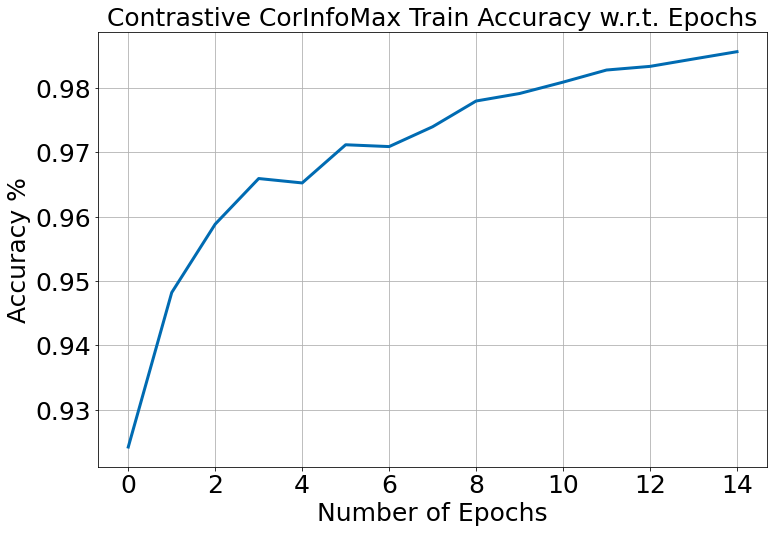

In [7]:
plot_convergence_plot(trn_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'Contrastive CorInfoMax Train Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

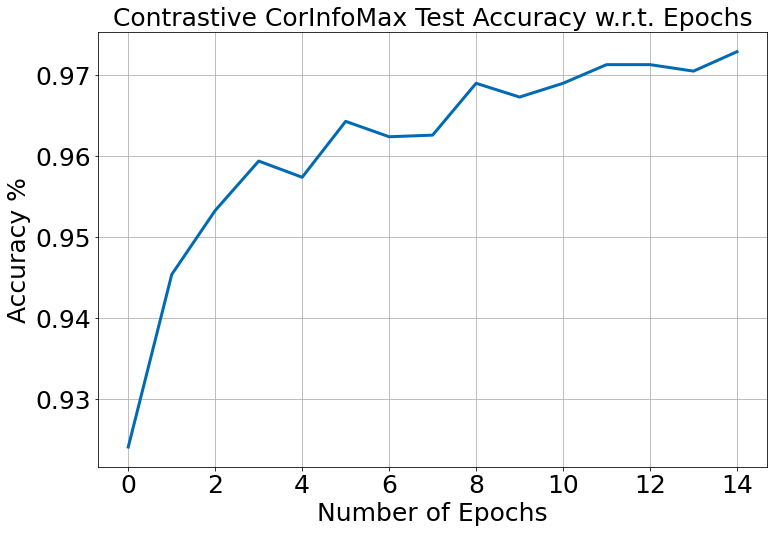

In [8]:
plot_convergence_plot(tst_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'Contrastive CorInfoMax Test Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)